# Data Preprocessing

In [0]:
# authenticate with Google Drive to load data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
import numpy as np
data_dir = 'gdrive/My Drive/project_data/'
X_test = np.load(data_dir + "X_test.npy")
y_test = np.load(data_dir + "y_test.npy")
person_train_valid = np.load(data_dir + "person_train_valid.npy")
X_train_valid = np.load(data_dir + "X_train_valid.npy")
y_train_valid = np.load(data_dir + "y_train_valid.npy")
person_test = np.load(data_dir + "person_test.npy")

In [0]:
# data seems to be loaded correc now
#print(X_train_valid.shape)

In [0]:

# Ignore EOG data from last 3 of 25 electrodes
# Transpose data so that the second dimension is timesteps
X_test = X_test[:, :-3, :]
X_test = X_test.transpose([0, 2, 1])
#X_train_valid = X_train_valid[:, :-3, :]
X_train_valid = X_train_valid.transpose([0, 2, 1])

In [0]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 1000, 25)
Test data shape: (443, 1000, 25)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
from sklearn import preprocessing

In [0]:
# reshaped to?
# good there is preproc here

scaler = preprocessing.StandardScaler()

X_reshaped = np.reshape(X_train_valid, (X_train_valid.shape[0]*X_train_valid.shape[1], X_train_valid.shape[2]))
scaler.fit(X_reshaped)

X_reshaped = scaler.transform(X_reshaped)
X_train_valid = np.reshape(X_reshaped, (X_train_valid.shape[0], X_train_valid.shape[1], X_train_valid.shape[2]))

X_test_reshaped = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_reshaped = scaler.transform(X_test_reshaped)
X_test = np.reshape(X_test_reshaped, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [0]:
print('shape after reshape')
print(X_train_valid.shape)
print(X_test.shape)

shape after reshape
(2115, 1000, 25)
(443, 1000, 25)


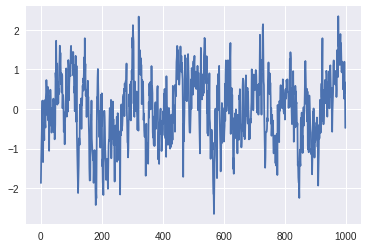

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(X_test[3, :, 14])

# Create Training/Validation Dataset, with Subsampling and Resampling 

In [0]:
np.random.seed(0)

In [0]:
# Turn labels into categories, i.e. y values of 0-3
le = preprocessing.LabelEncoder()
le.fit(y_train_valid)
y_train_valid_classes = le.transform(y_train_valid)
y_test_classes = le.transform(y_test)

In [0]:
rand_idx = np.random.permutation(X_train_valid.shape[0])
split = int(X_train_valid.shape[0] * 0.80) # 80-20%, check how util minibatch  distribs?

In [0]:
# Create randomized train and validation dataset split
X_train = X_train_valid[rand_idx][:split]
y_train = y_train_valid_classes[rand_idx][:split]
person_train = person_train_valid[rand_idx][:split]

X_valid = X_train_valid[rand_idx][split:]
y_valid = y_train_valid_classes[rand_idx][split:]
person_valid = person_train_valid[rand_idx][split:]


In [0]:
# CHANGE 16_3 8.08 pm checking beh with orig raw data 

# Downsample and resample data
from scipy import signal

X_train_downsampled = np.concatenate((X_train[:, 0::4, :], X_train[:, 1::4, :], X_train[:, 2::4, :], X_train[:, 3::4, :]))
X_train_processed = signal.resample(X_train_downsampled, 100, axis=1)
#X_train_processed= X_train

y_train_processed = np.concatenate((y_train, y_train, y_train, y_train))
#y_train_processed = y_train

person_train_processed = np.concatenate((person_train, person_train, person_train, person_train))
#person_train_processed = person_train

X_valid_downsampled = np.concatenate((X_valid[:, 0::4, :], X_valid[:, 1::4, :], X_valid[:, 2::4, :], X_valid[:, 3::4, :]))
X_valid_processed = signal.resample(X_valid_downsampled, 100, axis=1)
#X_valid_processed = X_valid

y_valid_processed = np.concatenate((y_valid, y_valid, y_valid, y_valid))
#y_valid_processed = y_valid

person_valid_processed = np.concatenate((person_valid, person_valid, person_valid, person_valid))
#person_valid_processed = person_valid

In [0]:
# shapes and dims after processing

num_trials = X_train_processed.shape[0]
num_timesteps = X_train_processed.shape[1]
num_features = X_train_processed.shape[2] # actually channels
num_valida_trials = X_valid_processed.shape[0]

print (num_features)

print(X_train_processed.shape) # 80% random split
print(y_train_processed.shape)
print(X_valid_processed.shape) # note this is the 20% validation data
print(y_valid_processed.shape)

25
(6768, 100, 25)
(6768,)
(1692, 100, 25)
(1692,)


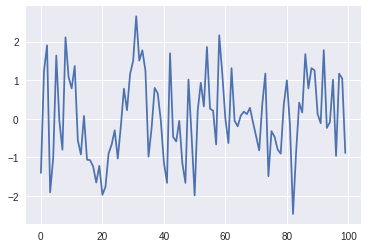

In [0]:
# plot after processing

#import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(X_valid_processed[3, :, 14])

In [0]:
# code for converting into img like

# X_train_processed , X_valid_processed

X_train_img =  np.zeros( (num_trials, num_features, num_features) ) # want it to be ntrax22x22
#X_valida_img =  np.zeros( (num_valida_trials, num_features , num_features) )

#for i in range(1):
  #print (X_train_processed[0,:,:].shape) # (100, 22), col row- corr

  
  
for k in range(num_trials): # for each obs
  
  #print(k)
  
  for j in range(num_features): # 1,2,....22
    
    a =  X_train_processed[k,:,j]
    
    for i in range(num_features): # 1,2,....22
      
      
      b = X_train_processed[k,:,i]
      #print(a.shape)
      X_train_img[k,j,i]= np.mean( np.convolve(a, b) ) # (22,) vimp mistake corrected,mistake X_train_img[j][i]
  
print(X_train_img.shape)
print('fskmsdkmflskmflkmf')
#print(X_train_img)
  


(6768, 25, 25)
fskmsdkmflskmflkmf


In [0]:
# repeat 1d convolu for valida

# code for converting into img like

# X_train_processed , X_valid_processed

#X_train_img =  np.zeros( (num_trials, num_features, num_features) ) # want it to be ntrax22x22
X_valida_img =  np.zeros( (num_valida_trials, num_features , num_features) )



  
  
for k in range(num_valida_trials): # for each obs
  
  #print(k)
  
  for j in range(num_features): # 1,2,....22
    
    a =  X_valid_processed[k,:,j]
    
    for i in range(num_features): # 1,2,....22
      
      
      b = X_valid_processed[k,:,i]
      #print(a.shape)
      X_valida_img[k,j,i]= np.mean( np.convolve(a, b) ) # (22,) vimp mistake corrected,mistake X_train_img[j][i]
  
print(X_valida_img.shape)
print('fskmsdkmflskmflkmf')
#print(X_train_img)
  


(1692, 25, 25)
fskmsdkmflskmflkmf


In [0]:
# Done- repeat img trans for valid data, check- check seems alright
# add utils
# add changes to tf code

# check for valida img trans
#print(X_valida_img[350,:,:])


# save img arrs
np.save('X_train_img.npy', X_train_img)
np.save('X_valida_img.npy', X_valida_img)




In [0]:
# tf utils

# add utils

# poten identation problem

############################
#
# Utility code for the 
# Sets up the train and test dataset to use and sets up random mini-batches.
############################

############################
#
# Utility code for the DTM learning.
# Sets up the train and test dataset to use and sets up random mini-batches.
############################

import math
#mport numpy as np
#import h5py
#import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops



# X_train_img.npy

def load_dataset():

########33


#######

# 21_5 implicit sfm data
  trafile= 'X_train_img'
  testfile= 'X_valida_img'

  #train_dataset = h5py.File(trafile, "r") #


  train_set_x_orig = np.load('X_train_img.npy')
  train_set_y_orig = y_train_processed # your train set labels


  test_dataset = np.load('X_valida_img.npy')
  test_set_x_orig = np.load('X_valida_img.npy') # your test set features
  test_set_y_orig = y_valid_processed # your test set labels

  #classes = np.array(test_dataset["list_classes"][:]) # the list of classes
  
  classes= np.array([0,1,2,3]) # check what format is expected 6_4

  #already stored in this shape
  #train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) # CHECK HERE 6/4
  #test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes,trafile # CHANGE 12_4- also returning file name


def random_mini_batches(X, Y, mini_batch_size = 256, seed = 0): # note default is 64
  """
  Creates a list of random minibatches from (X, Y)

  Arguments:
  X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
  Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
  mini_batch_size - size of the mini-batches, integer
  seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

  Returns:
  mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
  """

  m = X.shape[0]                  # number of training examples
  mini_batches = []
  np.random.seed(seed)

  # Step 1: Shuffle (X, Y) - anyway permuation hotay so we don't need to do it at start
  permutation = list(np.random.permutation(m))
  shuffled_X = X[permutation,:,:] # just permute directly on batch index!!!
  shuffled_Y = Y[permutation,:] # VERIFIED, both the labels have been shuffled properly according to X.

  ############### CHANGE 29_4 removed random permutation to check  interleaving
  #shuffled_X = X # just permute directly on batch index!!!
  #shuffled_Y = Y# VERIFIED, both the labels have been shuffled properly according to X.

  ############################


  # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
  num_complete_minibatches = np.uint32(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning

  for k in range(0, num_complete_minibatches):
    mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:] # sopay, just slide along
    mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)

  # Handling the end case (last mini-batch < mini_batch_size)
  if m % mini_batch_size != 0:
    mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:]
    mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)

  return mini_batches


def convert_to_one_hot(Y, C):
  Y = np.eye(C)[Y.reshape(-1)].T # select appropriate rows from ident matrix dep on the raw label vector
  return Y


def forward_propagation_for_predict(X, parameters):
  
  
  W1 = parameters['W1']
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']
  W3 = parameters['W3']
  b3 = parameters['b3']
                                                         # Numpy Equivalents:
  Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
  A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
  Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
  A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
  Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3

  return Z3



# add changes to tf code

In [0]:
# check loading from prev save
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes,trafile= load_dataset()
print(train_set_x_orig.shape)
print(train_set_y_orig.shape)
print(test_set_x_orig.shape)
print(test_set_y_orig.shape)

(6768, 25, 25)
(6768,)
(1692, 25, 25)
(1692,)


In [0]:
# coding: utf-8

# tf code will go here- change identation and other req details




#################
# The tensorflow code which implements proposed Deep Transformation Method (DTM).
# It contains the implementation of the transformation layer
# which produces cross-correlation matrices for the input time series data. This is followed by #convolution- ReLu- Max pool modules and fully connected layer for use in time series classification problems.

# We generate results on the EEG data for classifying actions.



##############


import os



########## import useful modules ###############
import math
#import numpy as np
#import h5py
# import matplotlib.pyplot as plt
import matplotlib

matplotlib.use('Agg')
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import seaborn as sns

# import scipy
from PIL import Image
# from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
# from implicit_cnn_utils import *
#from implicit_cnn_utils import *

sns.set_context("paper")
sns.set_style("whitegrid",
              {"grid.color": ".92", "ytick.major.size": "5", "xtick.major.size": "5", "legend.frameon": "False",
               "axes.edgecolor": "0.1", "axes.linewidth": "2", "axes.labelcolor": "0.1", "text.color": "0.1"})

# CHNGE fix the random seed, aleady set to 0
#np.random.seed(1)

# Loading the stored input data
# X_train_orig is the BOLD time series input of dim 90 x Tn (see paper for more details)
# Y_train_orig is a 90x 1 vector indicating
# 0: TDC and 1: ADHD, X_test and Y_test are the corresponding test matrices.
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes, dataname = load_dataset()

square_dim = 25  # CHANGE the number of brain regions in the input data

import PIL.Image as pil

# To get started, checking the shapes of the input data.

X_train = X_train_orig
X_test = X_test_orig

# convert Y to one hot encoding
Y_train = convert_to_one_hot(np.uint8(Y_train_orig), 4).T  # 16_3_CHANGE np.uint8
Y_test = convert_to_one_hot(np.uint8(Y_test_orig), 4).T

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))
conv_layers = {}


# ### 1.1 - Create placeholders
#
# TensorFlow requires that you create placeholders for the input data that will be fed into the model when running the session.
#

# create_placeholders

def create_placeholders(n_H0, n_W0, n_y):
  """
  Creates the placeholders for the tensorflow session.

  Arguments:
  n_H0 -- scalar, height of an input data (number of brain regions)
  n_W0 -- scalar, width of an input image (number of time points in the input time series)
  n_C0 -- scalar, number of channels of the input
  n_y -- scalar, number of classes

  Returns:
  X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
  Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
  """

  # X = tf.placeholder(tf.float32, shape= (None, n_H0, n_W0, n_C0))
  X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0))  # 21_5 CORRECT INIT to (,90,300)
  Y = tf.placeholder(tf.float32, shape=(None, n_y))

  return X, Y


# initialize_parameters

# note that this just provides the specifications to tf, the actual init happens only when you do global_variables init
def initialize_parameters():
  """
  Initializes weight parameters to build a DTM neural network with tensorflow. The shapes are:
                      W: [1,#channel,#channel] the implicit transform layer of the DTM
                      W1 : [4, 4, 3, 8] [filter h-w, inputcha, outputcha]- this will change as we modify
                      W2 : [2, 2, 8, 16]
  Returns:
  parameters -- a dictionary of tensors containing W1, W2
  """

  tf.set_random_seed(1)  # set the tensorflow seed

  # CHANGE 19_5: Adding the DTM hidden layer W
  # CAN add the W (90 x 90) - make it of dimension 22 x 22 and then
  # repeat to batch size where required

  # W is initialized randomly, the implicit transform captured by the weights of the DTM(W) eventually performs much better than the SFM transformation (see paper for details)
  # change to 22 x 22 for curr appli
  
  num_channels = 25
  
  W_load = tf.get_variable("W_load", [num_channels, num_channels], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  # CHANGE 16_3 weight window 90 to 22
  
  ######### specifying the weights of the DTM ##################
  W = tf.expand_dims(W_load, axis=0)  # expanded to 1,90,90
  W1 = tf.get_variable("W1", [4, 4, 1, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  ########################

  # return the weights as a parameter dictionary for later use
  parameters = {"W1": W1,
                "W2": W2,
                "W": W}

  return parameters


# forward_propagation

def forward_propagation(X, parameters, l2_weight, dropout):
  """
  Implements the forward propagation for the model:

 (BOLD time series)-> HTL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

  Arguments:
  X -- input dataset placeholder for the BOLD time-series data, of shape (input size, number of examples)
  parameters -- python dictionary containing your parameters "W1", "W2"
                the shapes are given in initialize_parameters

  Returns:
  Z3 -- the output of the last LINEAR unit
  """

  # tensorflow regularizer object
  regularizer = tf.contrib.layers.l2_regularizer(scale=l2_weight)

  # Retrieve the parameters from the dictionary "parameters"
  W = parameters['W']
  W1 = parameters['W1']
  W2 = parameters['W2']

  ############################
  # use the implicit transform W to get the 90 x 90 cross correlation matrices
  # Refer to the paper for more details
  ##################

  W = tf.tile(W, [tf.shape(X)[0], 1, 1])  # dim: (1,22,22) converted to (ntrain, 22,22)

  # imp: just append W on both sides to loaded xcorr . coz of linear property, we get trans of xcorr
  # rationale: since W is linear the transformation applied to cross correlations of X is
  # the same as the cross correlations of the transformed input (WX) [check paper for more details]

  left = tf.matmul(W, X)  # argument is that this is xcorr precomputa
  X = tf.matmul(left, W, transpose_b=True)  # 25_5 does WcorrW_T

  X = tf.expand_dims(X, axis=3)  # ntrain,90,90,1, this is the correlation matrix of the transfomed X ie Y= WX

  ############################# forward propogation of the proposed DTM
  # CONV2D: stride of 1, padding 'SAME'

  Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
  # RELU
  A1 = tf.nn.leaky_relu(Z1, alpha=0.2)
  # A1 = tf.nn.relu(Z1)
  # MAXPOOL: window 8x8, sride 8, padding 'SAME'
  P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')

  # CONV2D: filters W2, stride 1, padding 'SAME'
  Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')  # change P should be conv now
  # RELU
  A2 = tf.nn.leaky_relu(Z2, alpha=0.2)
  # A2 = tf.nn.relu(Z2)
  # MAXPOOL: window 4x4, stride 4, padding 'SAME'
  P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')

  # FLATTEN
  P2 = tf.contrib.layers.flatten(P2)
  # FULLY-CONNECTED without non-linear activation function as required by tf api
  # 2 neurons in output layer representing the class probabilities P(Y=1|X) and P(Y=0|X).
  Z3 = tf.contrib.layers.fully_connected(P2, 4, activation_fn=None, weights_regularizer=regularizer) # CHANGE 4 classes in fc out
  Z3_drop = tf.contrib.layers.dropout(Z3, dropout)  # adding dropout and returning that, CHANGE 8/4

  return X, Z3_drop  # CHANGE 22_5 returning the corr mats for sep cost computation


##########################################################:


# Compute cost

# pass in parameters to compute l2 loss
def compute_cost(Z3, Y, parameters, l2_weight, C, lsep_weight):
  """
  Computes the cost

  Arguments:
  Z3 -- output of forward propagation (output of the last LINEAR unit)
  Y -- "true" labels vector placeholder, same shape as Z3

  Returns:
  cost - Tensor of the cost function
  """
  W1 = parameters['W1']
  W2 = parameters['W2']  # later also retrieve fully connected weights

  cost_train = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))

  ##############################

  # Optional code to compute an explicit seperability cost, weighted by lsep_weight, not used
  # (ie lsep_weight= 0) eventually.

  # C has dims (371,90,90,1)

  # reduce_mean and ind by a dimension
  # 16_3 lsep calcs commmented out
#   labels = tf.argmax(Y, 1)  # just the label 1-d tensor
#   labels = tf.transpose(labels)  # to make sure it is n,1

#   condition = tf.equal(labels, 1)
#   adhd_indices = tf.where(condition)[:, 0]
#   C_sub_adhd = tf.gather(C, adhd_indices, axis=0)  # the adhd sub tensor

#   tdc_indices = tf.where(tf.equal(labels, 0))[:, 0]
#   C_sub_tdc = tf.gather(C, tdc_indices, axis=0)  # the adhd sub tensor

#   mean_adhd = tf.reduce_mean(C_sub_adhd, axis=0, keep_dims=True)
#   mean_tdc = tf.reduce_mean(C_sub_tdc, axis=0, keep_dims=True)

  #lsep_cost = 1 / (tf.norm(tf.subtract(mean_adhd, mean_tdc), ord='fro', axis=[-3, -2]))
  lsep_cost=0
  #################

  ##############################
  # compute total cost using the cost_train, lsep_cost and l2_loss

  cost = cost_train + lsep_weight * lsep_cost + l2_weight * (
    sum(tf.losses.get_regularization_losses())) + l2_weight * tf.nn.l2_loss(W1) + l2_weight * tf.nn.l2_loss(
    W2)  # add the two losses and divide by the number of 2*training samples ,

  return cost


# put the DTM model together and perform the learning using the training input
# hyperparameters are passed in as arguments to the function
def model(run_num, X_train, Y_train, X_test, Y_test, learning_rate=0.001, num_epochs=2500, minibatch_size=64,
          print_cost=True, l2_weight=0.0, lsep_weight=0,
          dropout=1):  # dropout is actually the drop-out keep probability
  """


  Arguments:
  X_train -- training set, of shape (None, 90, T_n, 1)
  Y_train -- test set, of shape (None, n_y = 2)
  X_test -- training set, of shape (None, 90, T_n, 1)
  Y_test -- test set, of shape (None, n_y = 2)
  learning_rate -- learning rate of the optimization
  num_epochs -- number of epochs of the optimization loop
  minibatch_size -- size of a minibatch
  print_cost -- True to print the cost every 100 epochs

  Returns:
  train_accuracy -- real number, accuracy on the train set (X_train)
  test_accuracy -- real number, testing accuracy on the test set (X_test)
  parameters -- parameters learnt by the model. They can then be used to predict.
  """
  print('...................')
  print("Run_num:", run_num)
  # print (run_num)
  print('...................')

  ops.reset_default_graph()  # to be able to rerun the model without overwriting tf variables
  tf.set_random_seed(1)  # to keep results consistent (tensorflow seed)
  seed = 3  # to keep results consistent (numpy seed)
  # (m, n_H0, n_W0, n_C0) = X_train.shape, w16_3 hy 3?
  (m, n_H0, n_W0) = X_train.shape
  n_y = Y_train.shape[1]
  costs = []  # To keep track of the cost

  # Create Placeholders of the correct shape

  # X, Y = create_placeholders(n_H0=n_H0,n_W0=n_W0,n_C0=n_C0,n_y=n_y)
  X, Y = create_placeholders(n_H0=n_H0, n_W0=n_W0, n_y=n_y)

  # Initialize parameters

  parameters = initialize_parameters()

  # Forward propagation: Build the forward propagation in the tensorflow graph

  # 22_5 C is the tensor containing the correlations for the current minibatch data
  C, Z3 = forward_propagation(X, parameters, l2_weight, dropout)  # not calc at once in vectorized fashion,

  # Cost function: Add cost function to tensorflow graph

  cost = compute_cost(Z3, Y, parameters, l2_weight, C, lsep_weight)

  # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.

  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

  # Initialize all the variables globally
  init = tf.global_variables_initializer()

  # Start the session to compute the tensorflow graph
  with tf.Session() as sess:

    # Run the initialization
    sess.run(init)

    # print('................................')
    # print('Counting params') # CHANGE 26_4- Adding number of parameters
    # print(np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))
    # print('................................')
    parameter_count = tf.reduce_sum([tf.reduce_prod(tf.shape(v)) for v in tf.trainable_variables()])
    print('................................')
    print("parameter_count =", sess.run(parameter_count))
    print('................................')

    # Do the training loop
    for epoch in range(num_epochs):

      minibatch_cost = 0.
      num_minibatches = int(m / minibatch_size)  # number of minibatches of size minibatch_size in the train set
      seed = seed + 1  # do we have to explicitly change the seed ourselves?
      minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)  # very nice method

      for minibatch in minibatches:
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        # IMPORTANT: The line that runs the graph on a minibatch.
        # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
        ### START CODE HERE ### (1 line)
        _, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
        ### END CODE HERE ###

        minibatch_cost += temp_cost / num_minibatches

      # Print the cost 5 epochs
      if print_cost == True and epoch % 5 == 0:
        print("Cost after epoch %i: %f" % (epoch, minibatch_cost))
      if print_cost == True and epoch % 1 == 0:
        costs.append(minibatch_cost)

    # Calculate the correct predictions
    predict_op = tf.argmax(Z3, 1)  # the arg 1 is for axis, the index of max is assumed to be pred class
    ylabel_op = tf.argmax(Y, 1)
    correct_prediction = tf.equal(predict_op, ylabel_op)  # the argmax here is to conv 1 hot back to label
    # how to extract predict_op (y_hat) and ylabel_op(y_true)
    # Calculate accuracies
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))  # this defines the accuracy graph operations
    # print(accuracy)

    # finally after training - get the pred, true y and the accuracy
    print('Calcu the accuracies...')
    # train_accuracy = accuracy.eval({X: X_train, Y: Y_train}) # even this is a graph operation, check if getting printed

    test_result_vals = sess.run([accuracy, ylabel_op, predict_op],
                                feed_dict={X: X_test, Y: Y_test})  # this works, thats why it is called fetches

    test_accuracy = test_result_vals[0]
    print(str(run_num) + " Test Accuracy:", test_accuracy)

    ####################################
    # get test confu mat and other metrics
    new_acc_score = accuracy_score(test_result_vals[1], test_result_vals[2])
    test_confu = confusion_matrix(test_result_vals[1], test_result_vals[2])
    preci = precision_score(test_result_vals[1], test_result_vals[2], average='macro')
    sensi = recall_score(test_result_vals[1], test_result_vals[2],average='macro')
    f1 = f1_score(test_result_vals[1], test_result_vals[2],average='macro')

    
    #tn, fp, fn, tp = confusion_matrix(test_result_vals[1], test_result_vals[2]).ravel()
    #specifi = float(tn) / (tn + fp)
    # print confusion matrix- CHANGE 12_4
    print('........................')
    print(test_confu)  # put in true and pred labels
    print('we are printing test results')
    print(new_acc_score) # this is the test score - check for manashanti
    print(preci)
    print(sensi)
    print(f1)
    print('test results print ended')
    #print(specifi)
    # save test confu and the calculated metrics in text files- named by data
    print('........................')

    metrics = []
    #metrics.append(test_result_vals[0])
    metrics.append(new_acc_score)
    metrics.append(preci)
    metrics.append(sensi)
    metrics.append(f1)
    #metrics.append(specifi)

    metrics = np.asarray(metrics)  # conv to np array
    cwd = os.getcwd()
    print(cwd)
    # save as .txt files
#     np.savetxt(cwd + '/Results/Runs/23_5_implicit_corr/' + dataname + 'Run_' + str(run_num) + '_testmetrics.txt',
#                metrics, delimiter=' ')  # save the metrics file
#     np.savetxt(cwd + '/Results/Runs/23_5_implicit_corr/' + dataname + 'Run_' + str(run_num) + '_testconfu.txt',
#                test_confu, delimiter=' ')  # save the test confu mat
#     np.savetxt(cwd + '/Results/Runs/LabelnPred/' + 'Run_' + str(run_num) + dataname + '_testlabel.txt',
#                test_result_vals[1], delimiter=' ')
#     np.savetxt(cwd + '/Results/Runs/LabelnPred/' + dataname + 'Run_' + str(run_num) + '_testpredic.txt',
#                test_result_vals[2], delimiter=' ')

    np.savetxt('gdrive/My Drive/result_dump/' + dataname + 'Run_' + str(run_num) + '_testmetrics.txt',
               metrics, delimiter=' ')  # save the metrics file
    np.savetxt('gdrive/My Drive/result_dump/' + dataname + 'Run_' + str(run_num) + '_testconfu.txt',
               test_confu, delimiter=' ')  # save the test confu mat
    np.savetxt('gdrive/My Drive/result_dump/' + 'Run_' + str(run_num) + dataname + '_testlabel.txt',
               test_result_vals[1], delimiter=' ')
    np.savetxt('gdrive/My Drive/result_dump/' + dataname + 'Run_' + str(run_num) + '_testpredic.txt',
               test_result_vals[2], delimiter=' ')
    
    #gdrive/My Drive/result_dump/
    ###################################
    # save the cost data
    cost_data = np.squeeze(costs)
    # savefilecost= dataname+'_costfile.h5'
    # h5f = h5py.File(cwd+'/Results/Runs/'+'Run_'+str(run_num)+savefilecost, 'w')
    # h5f.create_dataset('costarr', data=cost_data)
    # h5f.close()

    # save the image for the cost data
    plt.plot(cost_data)
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title("Learning rate =" + str(learning_rate))
    plt.savefig('gdrive/My Drive/result_dump/' + dataname + 'Run_' + str(run_num) + '_learning_curve.png',
                dpi=600)  # check
    # plt.show()

    ###################################
    # compute metrics on train data

    train_result_vals = sess.run([accuracy, ylabel_op, predict_op],
                                 feed_dict={X: X_train, Y: Y_train})  # this works, thats why it is called fetches
    train_accuracy = train_result_vals[0]
    print(str(run_num) + " train Accuracy:", train_accuracy)

    new_acc_score = accuracy_score(train_result_vals[1], train_result_vals[2])
    train_confu = confusion_matrix(train_result_vals[1], train_result_vals[2])
    preci = precision_score(train_result_vals[1], train_result_vals[2], average='macro')
    sensi = recall_score(train_result_vals[1], train_result_vals[2],average='macro')
    f1 = f1_score(train_result_vals[1], train_result_vals[2],average='macro')

    #tn, fp, fn, tp = confusion_matrix(train_result_vals[1], train_result_vals[2]).ravel()
    #specifi = float(tn) / (tn + fp)
    # print confusion matrix- CHANGE 12_4
    print('........................')
    print(train_confu)  # put in true and pred labels
    print('.........Printing train metrics...............')
    print(new_acc_score)
    print(preci)
    print(sensi)
    print(f1)
    #print(specifi)
    # save test confu and the calculated metrics in text files- named by data, check if working and then move to train confu
    print('....end printing train metrics....................')

    metrics = []
    metrics.append(train_result_vals[0])
    metrics.append(preci)
    metrics.append(sensi)
    metrics.append(f1)
    #metrics.append(specifi)

    metrics = np.asarray(metrics)  # conv to np array
    cwd = os.getcwd()

#     np.savetxt(cwd + '/Results/Runs/23_5_implicit_corr/' + dataname + 'Run_' + str(run_num) + '_trainmetrics.txt',
#                metrics, delimiter=' ')  # save the metrics file
#     np.savetxt(cwd + '/Results/Runs/23_5_implicit_corr/' + dataname + 'Run_' + str(run_num) + '_trainconfu.txt',
#                train_confu, delimiter=' ')
#     np.savetxt(cwd + '/Results/Runs/LabelnPred/' + 'Run_' + str(run_num) + dataname + '_trainlabel.txt',
#                train_result_vals[1], delimiter=' ')
#     np.savetxt(cwd + '/Results/Runs/LabelnPred/' + dataname + 'Run_' + str(run_num) + '_trainpredic.txt',
#                train_result_vals[2], delimiter=' ')

    np.savetxt('gdrive/My Drive/result_dump/' + dataname + 'Run_' + str(run_num) + '_trainmetrics.txt',
               metrics, delimiter=' ')  # save the metrics file
    np.savetxt('gdrive/My Drive/result_dump/' + dataname + 'Run_' + str(run_num) + '_trainconfu.txt',
               train_confu, delimiter=' ')  # save the test confu mat
    np.savetxt('gdrive/My Drive/result_dump/' + 'Run_' + str(run_num) + dataname + '_trainlabel.txt',
               train_result_vals[1], delimiter=' ')
    np.savetxt('gdrive/My Drive/result_dump/' + dataname + 'Run_' + str(run_num) + '_trainpredic.txt',
               train_result_vals[2], delimiter=' ')
    
    return train_accuracy, test_accuracy, parameters


#######################################################


######## also save the hyperparameters
# hyps= []
# hyps.append(learning_rate)
# learning_rate = 0.001,num_epochs = 70, minibatch_size = 32, print_cost = True, l2_weight=0.001, lsep_weight=0.00,dropout=1

# pickle parameters






number of training examples = 6768
number of test examples = 1692
X_train shape: (6768, 25, 25)
Y_train shape: (6768, 4)
X_test shape: (1692, 25, 25)
Y_test shape: (1692, 4)


...................
Run_num: 0
...................

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

................................
parameter_count = 1333
................................
Cost after epoch 0: 1.407828
Cost after epoch 5: 1.381558
Cost after epoch 10: 1.361686
Cost after epoch 15: 1.343230
Cost after epoch 2

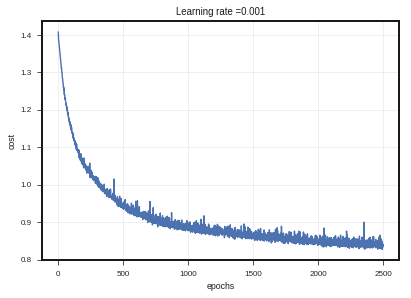

In [0]:
# MAIN CELL

# MAIN function, run the model

# 4_5 We generate several random train test cross validation splits. We run a very simple
# global optimization by using different random initializations of the gradient descent and reporting the best test error achieved.

total_runs = 1 # change 16_3 only 1 run for now, not 25

train_accu_list = []
test_accu_list = []  # find max index of test accu

for run_num in range(0, total_runs):
  curr_train_acc, curr_test_acc, parameters = model(run_num, X_train, Y_train, X_test, Y_test)

  train_accu_list.append(curr_train_acc)
  test_accu_list.append(curr_test_acc)

# perform global optimization using simultaneuos searches
print('....................')
print('printing all test accus')
print(test_accu_list)
print('....................')

max_test_acc = max(test_accu_list)
max_test_acc_index = test_accu_list.index(max_test_acc)
print('max test acc: ', max_test_acc)
print('max test acc run index: ', max_test_acc_index)
# find max train acc and the run number
max_train_acc = max(train_accu_list)
max_train_acc_index = train_accu_list.index(max_train_acc)
print('max train acc: ', max_train_acc)

print('................')
print('avg test accuracy: ', sum(test_accu_list) / float(len(test_accu_list)))
print('avg train accuracy: ', sum(train_accu_list) / float(len(train_accu_list)))

print('................')
